# Liquid biopsy benchmark

In [1]:
# Imports

import io
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pysam
import warnings
from sklearn.metrics import precision_recall_curve, f1_score
warnings.filterwarnings('ignore')

# set working directory
if not os.getcwd().endswith('cfdna_snv_benchmark'):
    os.chdir('../')
print('Current working directory: {}'.format(os.getcwd()))

from utils.config import Config
from utils.viz import *

Current working directory: /Users/hanae/Repositories/cfdna_snv_benchmark


In [8]:
# Config and Display paramaters

config = Config("config/", "config_viz.yaml")
#set_display_params(config)

fraction_list = ['', '_T40', '_T20'] # tumor purity 100%, 40% and 20%
f_list = [1, 0.4, 0.2]
samples = ['icgc_cll_tumour' , 'icgc_mbl_tumour']
purity_dict = {'icgc_cll_tumour': 0.92,  'icgc_mbl_tumour': 0.98} # source: Weitai
color_dict = {config.methods[i]: config.colors[i] for i in range(len(config.methods))}

# Precision - Recall curve

In [ ]:
  """
    dilutiondirpath = ["..", "data", "dilutions_chr22"]
    bcbiooutputdirpath = ["..", "data", "bcbio_output"]
    prefix = 'dilution_chr22_'
    chrom = '22'
    plasmasample1 = 'CRC-986_100215'
    methods = ['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan']
    vcf_path = os.path.join(*bcbiooutputdirpath, prefix + plasmasample1 + "_1_pooledhealthy_0",
                            prefix + plasmasample1 + "_1_pooledhealthy_0-ensemble-annotated.vcf")
    vcf_ref = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
    vcf_ref = vcf_ref[vcf_ref['type'] == 'SNV']
    y_true = pd.DataFrame(vcf_ref[methods].T.sum())
    y_true.columns = ['truth']
    y_true['truth'][y_true['truth'] <= 1] = 0
    y_true = y_true.astype(bool)
    #y_true['CHROM'] = y_true.index.str.split('_').str[0]
    #y_true['POS'] = y_true.index.str.split('_').str[1]
    #print(y_true)
    #vcf_path = os.path.join(*bcbiooutputdirpath, prefix + plasmasample1 + "_1_pooledhealthy_0",
    #                        prefix + plasmasample1 + "_1_pooledhealthy_0-ensemble-annotated.vcf")
    vcf_path = os.path.join(*bcbiooutputdirpath, prefix + plasmasample1 + "_1_CRC-986_300316_0.72",
                            prefix + plasmasample1 + "_1_CRC-986_300316_0_72-ensemble-annotated.vcf")
    vcf_sample = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
    vcf_sample = vcf_sample[vcf_sample['type'] == 'SNV']
    print(vcf_sample.shape, y_true.shape)
    #vcf_sample = pd.merge(vcf_sample, y_true, how='outer', on=["CHROM", "POS"])
    #df_sample = pd.concat([vcf_sample, y_true], join='outer', axis=1)
    df_sample = vcf_sample.join(y_true, how='outer') # not concat because duplicated axis
    # prt = pr_table(vcf_sample, 'freebayes_score', 'truth', verbose=True, decreasing=False)
    # print(prt)

    from sklearn.metrics import precision_recall_curve

    fig, ax = plt.subplots()
    for method in methods:
        df_sample_method = df_sample[['truth', method + '_score']]
        df_sample_method['truth'].fillna(False, inplace=True)
        df_sample_method[method + '_score'].fillna(0, inplace=True)
        print(df_sample_method)
        precision, recall, thresholds = precision_recall_curve(df_sample_method['truth'], df_sample_method[method + '_score'])
        plot_pr_curve(precision, recall, estimator_name=method, f1_score=None, figax=(fig, ax))
    plt.show()
    

    dilutiondirpath = ["..", "data", "dilutions_chr22"]
    bcbiooutputdirpath = ["..", "data", "bcbio_output"]
    prefix = 'dilution_chr22_'
    chrom = '22'
    plasmasample1 = 'CRC-986_100215'
    methods = ['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan']
    #vcf_path = os.path.join(*bcbiooutputdirpath, prefix + plasmasample1 + "_1_CRC-986_300316_0.72",
    #                        prefix + plasmasample1 + "_1_CRC-986_300316_0_72-ensemble-annotated.vcf")
    vcf_path = os.path.join(*bcbiooutputdirpath, prefix + plasmasample1 + "_0.125_CRC-986_300316_0.875",
                            prefix + plasmasample1 + "_0_125_CRC-986_300316_0_875-ensemble-annotated.vcf")
    vcf_sample = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
    vcf_sample = vcf_sample[vcf_sample['type'] == 'SNV']
    vcf_path = os.path.join(*bcbiooutputdirpath, prefix + plasmasample1 + "_1_pooledhealthy_0",
                            prefix + plasmasample1 + "_1_pooledhealthy_0-ensemble-annotated.vcf")
    vcf_ref = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
    vcf_ref = vcf_ref[vcf_ref['type'] == 'SNV']

    from sklearn.metrics import precision_recall_curve

    fig, ax = plt.subplots()
    for method in methods:
        y_true = vcf_ref[[method]]
        y_true.columns = ['truth']
        y_true = y_true.astype(bool)
        df_sample = vcf_sample.join(y_true, how='outer') # not concat because duplicated axis
        df_sample_method = df_sample[['truth', method + '_score']]
        df_sample_method['truth'].fillna(False, inplace=True)
        df_sample_method[method + '_score'].fillna(0, inplace=True)
        print(method)
        print(df_sample_method[method + '_score'].describe())
        precision, recall, thresholds = precision_recall_curve(df_sample_method['truth'], df_sample_method[method + '_score'])
        plot_pr_curve(precision, recall, estimator_name=method, f1_score=None, figax=(fig, ax))
    plt.show()
    """

icgc_cll_tumour
icgc_cll_tumour
icgc_cll_T40_tumour
icgc_cll_T20_tumour


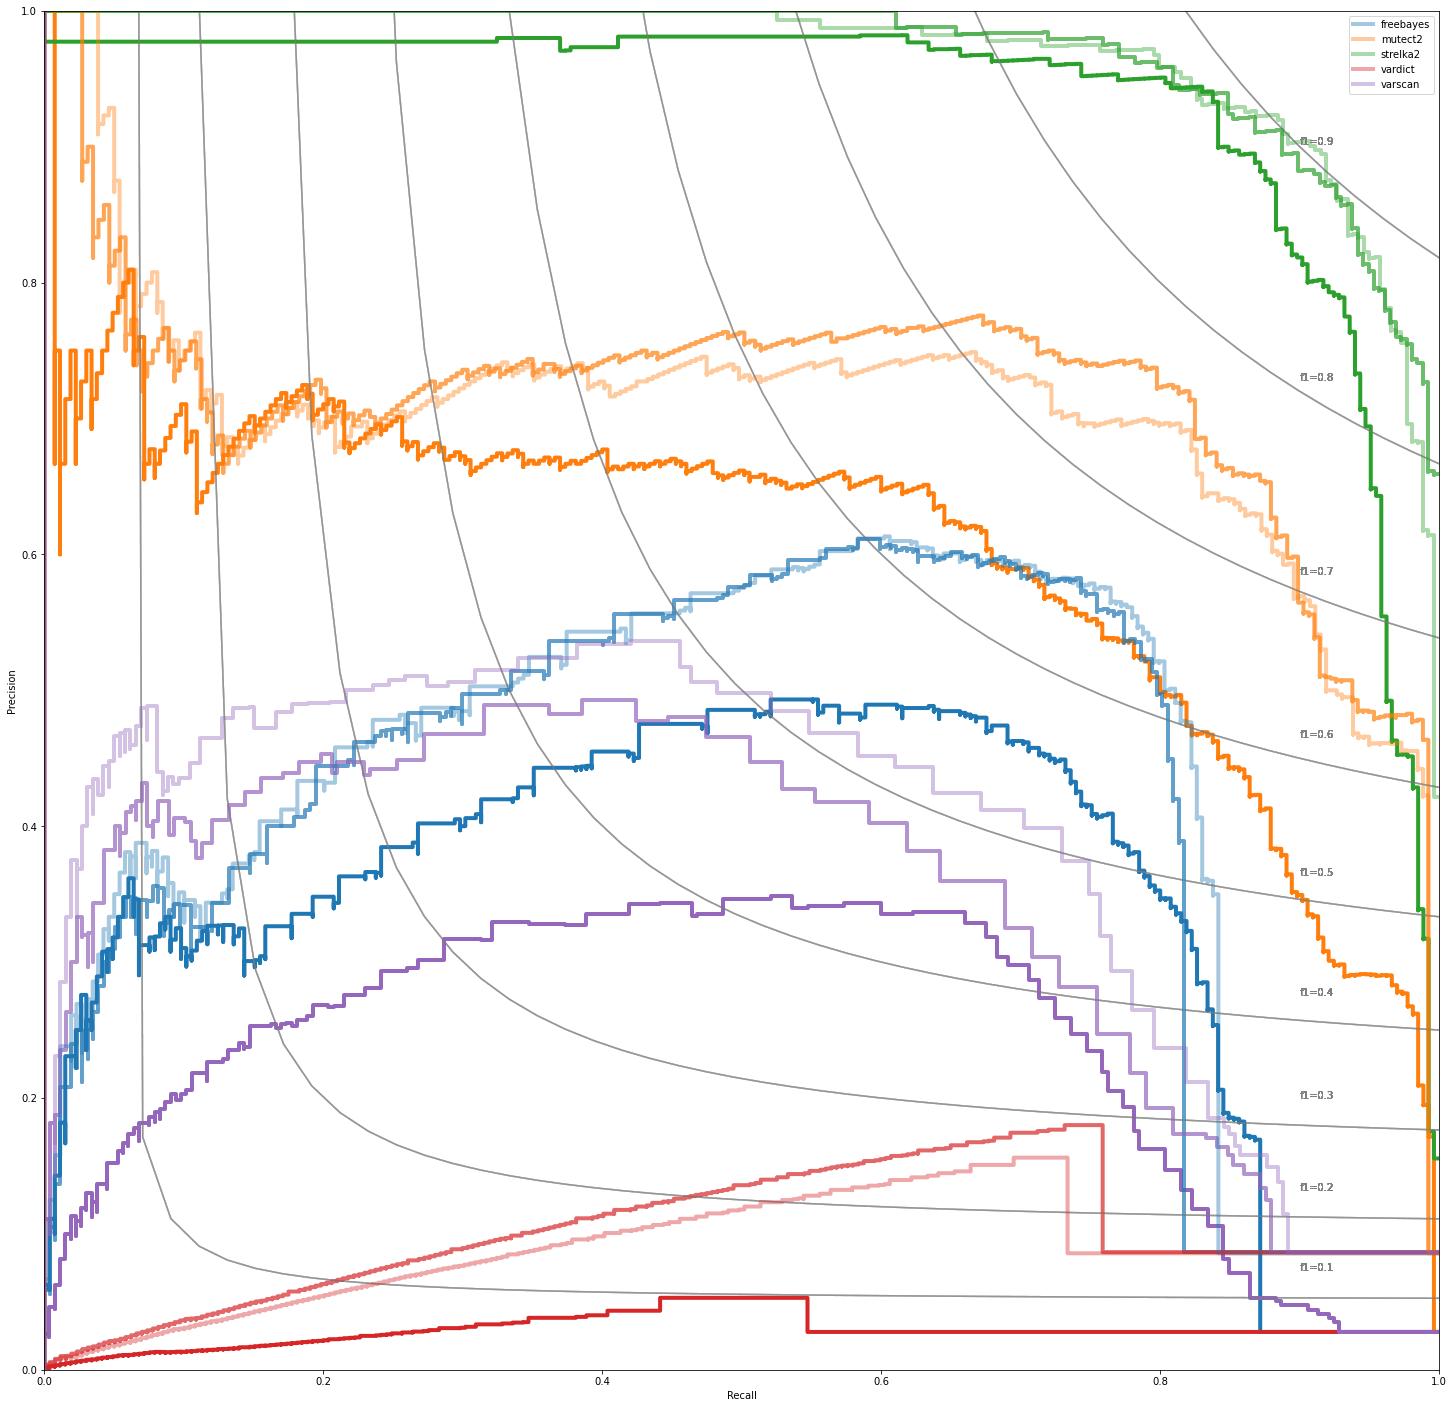

icgc_mbl_tumour
icgc_mbl_tumour
icgc_mbl_T40_tumour
icgc_mbl_T20_tumour


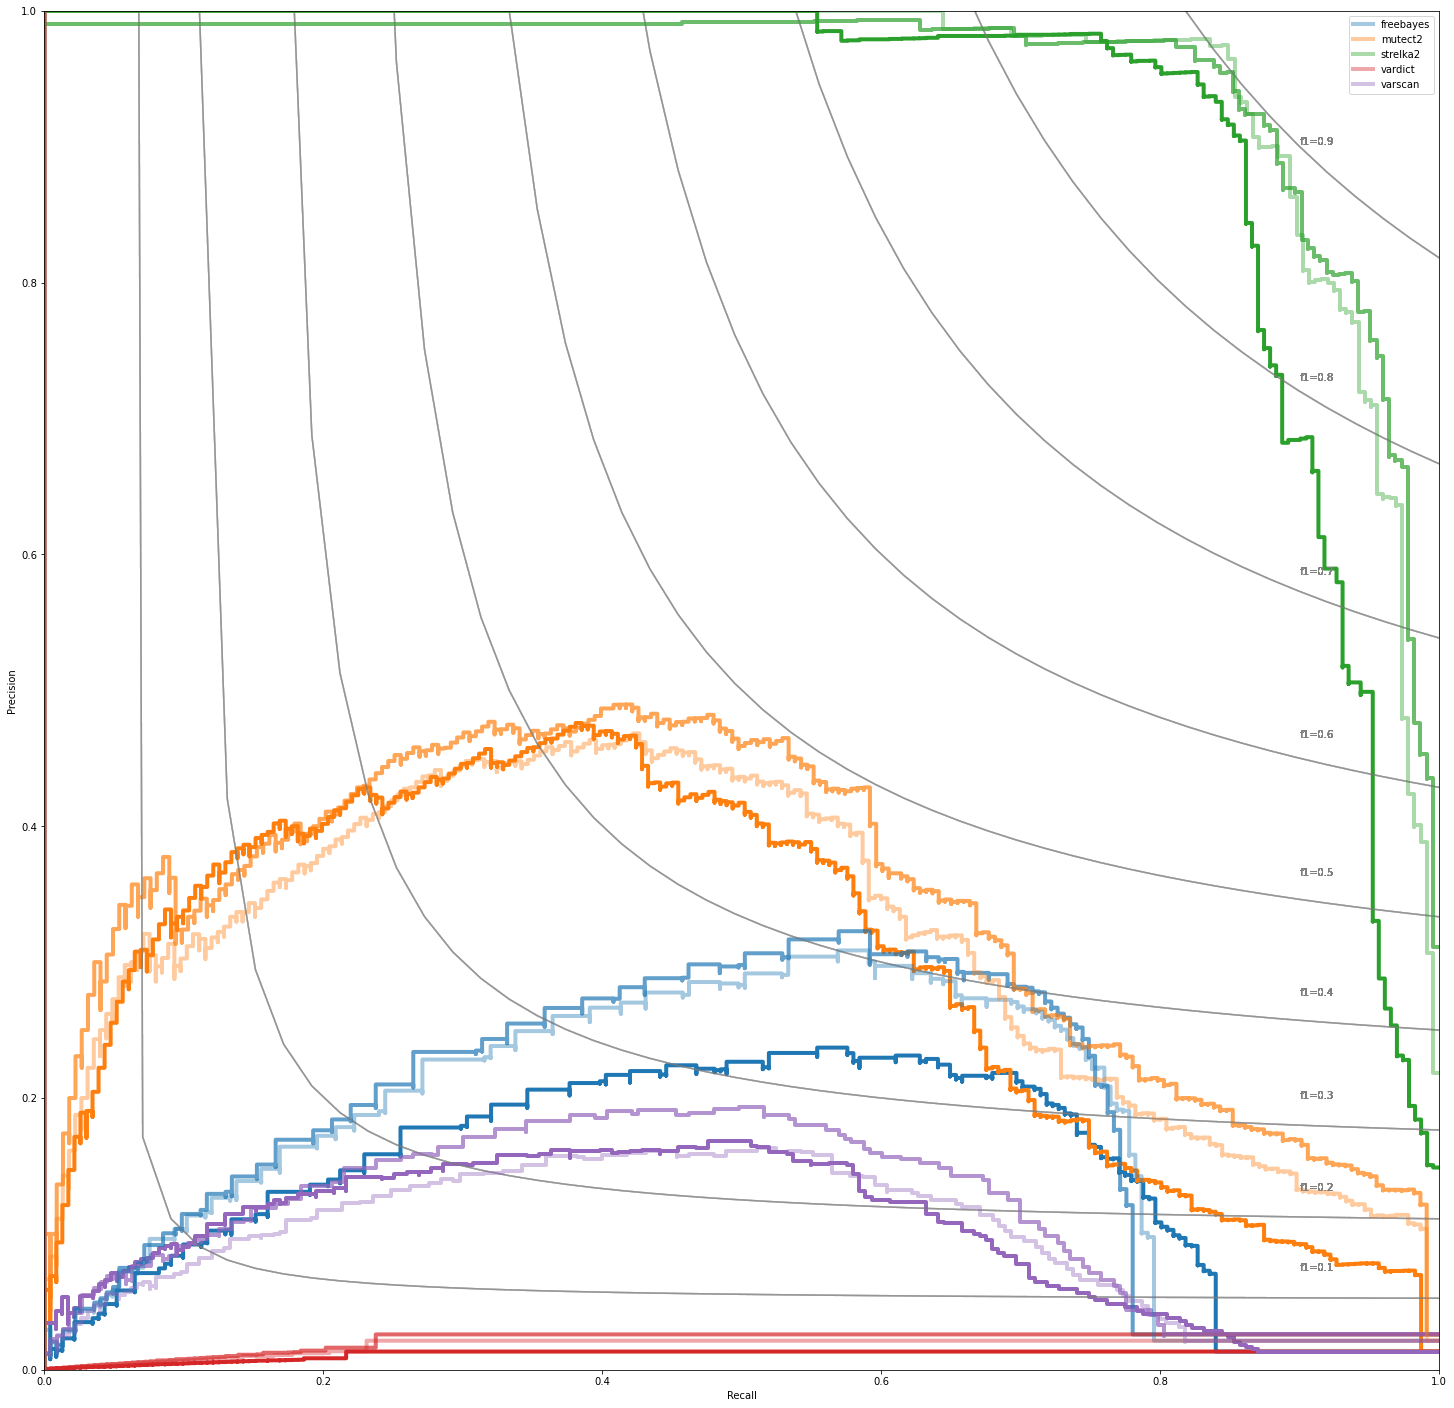

In [3]:
vcf_path = os.path.join(*config.tissuebenchmark, "snv-smurf-test20-v7-new5-maxdepth-2.tsv")
vcf_samples = pd.read_csv(vcf_path, sep='\t')
alpha_dict = {'icgc_cll_tumour': 1, "icgc_cll_T40_tumour": 0.8, 'icgc_cll_T20_tumour': 0.5}

for sample in samples:
    print(sample)
    sample_fractions = ['_'.join(sample.split('_')[:-1]) + f + '_'+ sample.split('_')[-1] for f in fraction_list]
    alpha_dict = {sample_fractions[i]: 1-0.3*i for i in range(len(fraction_list))}
    fig, ax = plt.subplots(figsize=(25,25))
    for s in sample_fractions:
        print(s)
        vcf_sample = vcf_samples[vcf_samples['Sample_Name'] == s]
        vcf_sample.reset_index(inplace=True)
        vcf_sample['CHROM_POS'] = vcf_sample['X.CHROM'].astype('str').str.cat(vcf_sample['POS'].astype('str'), sep="_")
        vcf_sample.set_index('CHROM_POS', inplace=True)
        vcf_sample['mutect2_score'] = vcf_sample['m2_TLOD']
        vcf_sample['freebayes_score'] = vcf_sample['f_ODDS']
        vcf_sample['strelka2_score'] = vcf_sample['s2_SomaticEVS']
        vcf_sample['varscan_score'] = vcf_sample['vs_SSC']
        vcf_sample['vardict_score'] = vcf_sample['vd_SSF']

        for method in config.methods:
            df_sample_method = vcf_sample[[method+'_score', 'TRUTH']]
            df_sample_method[method + '_score'].fillna(0, inplace=True)
            #print(method)
            #print(df_sample_method[method + '_score'].describe())
            precision, recall, thresholds = precision_recall_curve(df_sample_method['TRUTH'], df_sample_method[method + '_score'])
            f1 = f1_score(vcf_sample['TRUTH'], vcf_sample['FILTER_'+method[0].upper()+method[1:]])
            plot_pr_curve(precision, recall, estimator_name=method, f1_score=None, figax=(fig, ax), kwargs={'color':color_dict[method], 'alpha':alpha_dict[s], 'lw':4})
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.show()

# F1-score plot

icgc_cll_tumour
icgc_mbl_tumour
icgc_mbl_T40_tumour
icgc_mbl_T20_tumour
icgc_mbl_tumour
icgc_mbl_tumour
icgc_mbl_T40_tumour
icgc_mbl_T20_tumour


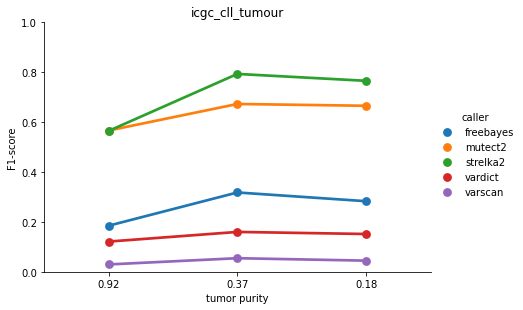

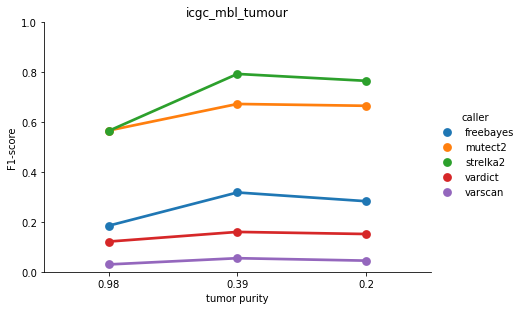

In [20]:
vcf_path = os.path.join(*config.tissuebenchmark, "snv-smurf-test20-v7-new5-maxdepth-2.tsv")
vcf_samples = pd.read_csv(vcf_path, sep='\t')
alpha_dict = {'icgc_cll_tumour': 1, "icgc_cll_T40_tumour": 0.8, 'icgc_cll_T20_tumour': 0.5}

results_df = pd.DataFrame()
aux_f1 = []
aux_method = []
aux_sample = []
aux_tp = []

for sample in samples:
    print(sample)
    for i, s in enumerate(sample_fractions):
        print(s)
        vcf_sample = vcf_samples[vcf_samples['Sample_Name'] == s]
        vcf_sample.reset_index(inplace=True)
        vcf_sample['CHROM_POS'] = vcf_sample['X.CHROM'].astype('str').str.cat(vcf_sample['POS'].astype('str'), sep="_")
        vcf_sample.set_index('CHROM_POS', inplace=True)
        vcf_sample['mutect2_score'] = vcf_sample['m2_TLOD']
        vcf_sample['freebayes_score'] = vcf_sample['f_ODDS']
        vcf_sample['strelka2_score'] = vcf_sample['s2_SomaticEVS']
        vcf_sample['varscan_score'] = vcf_sample['vs_SSC']
        vcf_sample['vardict_score'] = vcf_sample['vd_SSF']

        for method in config.methods:
            df_sample_method = vcf_sample[[method+'_score', 'TRUTH']]
            df_sample_method[method + '_score'].fillna(0, inplace=True)
            f1 = f1_score(vcf_sample['TRUTH'], vcf_sample['FILTER_'+method[0].upper()+method[1:]])
            aux_f1.append(f1)
            aux_method.append(method)
            aux_sample.append(sample)
            aux_tp.append(round(purity_dict[sample]*f_list[i], 2))
    
results_df['F1-score'] = aux_f1
results_df['tumor purity'] = aux_tp
results_df['caller'] = aux_method
results_df['sample'] = aux_sample
    
    
for si, sample in enumerate(samples):
    sns.catplot(x="tumor purity", y="F1-score", hue="caller",
              capsize=.2, height=4, aspect=1.5, kind="point",
                order=sorted(results_df[results_df['sample'] == sample]['tumor purity'].unique(), reverse=True),
                    data=results_df[results_df['sample'] == sample])
    #plt.axhline(y = baselineAUPRC, color = 'w', linestyle = '--', label='baseline AUPRC') 
    plt.ylim([0, 1])
    plt.title(sample)